In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


here the objective is to fit the logit graph model to multiple different graph domains and then visualize the original vs fitted graphs

In [41]:

import sys
import os

#Graph imports
sys.path.append('../..')
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

from src.simulation import LogitGraphFitter, GraphModelComparator

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [42]:
data_directory = f'../../data/REDDIT-MULTI-12K'
os.listdir(data_directory)

['REDDIT-MULTI-12K.graph_idx',
 'component_1975.edges',
 'component_2610.edges',
 'REDDIT-MULTI-12K.graph_labels',
 'REDDIT-MULTI-12K.readme',
 'readme.html',
 'component_3599.edges',
 'component_2848.edges',
 'component_3726.edges',
 'component_3586.edges',
 'component_3440.edges',
 'component_3235.edges',
 'component_4077.edges',
 'REDDIT-MULTI-12K.edges',
 'component_2156.edges']

In [43]:
def load_reddit_graph(data_dir, filename):
    """
    Loads a graph from the specified directory and filename.

    Args:
        data_dir (str): The directory where the data is stored.
        filename (str): The name of the file to load.

    Returns:
        networkx.Graph: The loaded graph as a networkx Graph object.
    """
    edge_file = os.path.join(data_dir, filename)
    
    G = nx.Graph()
    
    with open(edge_file, 'r') as f:
        for line in f:
            # The files are comma-separated, so we split the line
            # and convert the node IDs to integers.
            u, v = map(int, line.strip().split(','))
            G.add_edge(u, v)
            
    return G


graphs = []
graph_filepaths = {}
filename = 'REDDIT-MULTI-12K.edges'
graph = load_reddit_graph(data_directory, filename)
if graph:
    graphs.append(graph)
    graph_filepaths[graph] = os.path.join(data_directory, filename)
    print(f"Graph {filename} loaded successfully. Edges: {graph.number_of_edges()}, Nodes: {graph.number_of_nodes()}")


Graph REDDIT-MULTI-12K.edges loaded successfully. Edges: 5450243, Nodes: 4669027


In [44]:
graph = graphs[0]

import pandas as pd

# Calculate connected components
connected_components = list(nx.connected_components(graph))
component_data = []

# Collect data for each component
for i, component in enumerate(connected_components):
    subgraph = graph.subgraph(component)
    num_nodes = subgraph.number_of_nodes()
    num_edges = subgraph.number_of_edges()
    component_data.append({
        'component': i + 1,
        'num_nodes': num_nodes,
        'num_edges': num_edges
    })

# Create a DataFrame
component_df = pd.DataFrame(component_data)

In [48]:
component_df.sort_values(by='num_nodes', ascending=False).head(100)


,component,num_nodes,num_edges
21522,21523,3760,4058
21518,21519,3642,4003
10871,10872,3624,3766
26780,26781,3606,4334
31789,31790,3533,5166
...,...,...,...
30208,30209,2348,3457
4602,4603,2338,2798
3921,3922,2338,2587
5027,5028,2337,2582


In [50]:
import os
target_directory = data_directory
selected_components = component_df[(component_df['num_nodes'] >= 1000) & (component_df['num_nodes'] <= 5000)]

# Sample 20
sample_components = selected_components.sample(20)
sample_components, sample_components.shape, selected_components.num_nodes.max(), selected_components.num_nodes.min()

(       component  num_nodes  num_edges
 21697      21698       1601       1762
 29884      29885       1747       2866
 10791      10792       1877       2100
 4898        4899       1474       1749
 11001      11002       3421       3656
 30634      30635       1461       1945
 30100      30101       1190       1606
 6698        6699       1142       1456
 7631        7632       1262       1430
 6657        6658       1400       1737
 29274      29275       1017       1237
 3585        3586       1012       1112
 6600        6601       1243       1367
 18244      18245       1432       1493
 27555      27556       1161       1416
 6931        6932       1469       1649
 5916        5917       1247       1458
 6641        6642       1918       2285
 5575        5576       1142       1370
 17742      17743       1307       1681,
 (20, 3),
 3760,
 1000)

In [57]:
folder_path = '../../data/reddit_connected/'
os.makedirs(folder_path, exist_ok=True)

for index, row in sample_components.iterrows():
    selected_component = row['component']
    #component_nodes = list(graph.subgraph(row['component']).nodes)
    component_nodes = connected_components[selected_component - 1]
    print(component_nodes)
    subgraph = graph.subgraph(component_nodes)
    print(subgraph.number_of_nodes(), subgraph.number_of_edges())
    
    # Check if the subgraph has more than 1 node and at least 1 edge
    if subgraph.number_of_nodes() > 1 and subgraph.number_of_edges() > 0:
        # Define the file path
        filepath = os.path.join(folder_path, f"component_{selected_component}.edges")
        
        # Write the edges to the file
        with open(filepath, 'w') as f:
            for u, v in subgraph.edges():
                f.write(f"{u},{v}\n")
        
        print(f"Component {selected_component} saved with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges.")
    else:
        print(f"Component {selected_component} skipped due to insufficient nodes or edges.")


{3138168, 3138169, 3138170, 3138171, 3138172, 3138173, 3138174, 3138175, 3138176, 3138177, 3138178, 3138179, 3138180, 3138181, 3138182, 3138183, 3138184, 3138185, 3138186, 3138187, 3138188, 3138189, 3138190, 3138192, 3138193, 3138194, 3138195, 3138196, 3138197, 3138198, 3138200, 3138201, 3138202, 3138203, 3138204, 3138205, 3138206, 3138207, 3138208, 3138210, 3138211, 3138212, 3138213, 3138214, 3138215, 3138216, 3138217, 3138218, 3138219, 3138220, 3138221, 3138222, 3138223, 3138224, 3138226, 3138227, 3138229, 3138230, 3138231, 3138232, 3138233, 3138235, 3138236, 3138237, 3138238, 3138239, 3138240, 3138241, 3138242, 3138243, 3138244, 3138245, 3138246, 3138247, 3138248, 3138249, 3138250, 3138251, 3138252, 3138253, 3138254, 3138255, 3138256, 3138257, 3138258, 3138259, 3138260, 3138261, 3138262, 3138263, 3138264, 3138265, 3138266, 3138267, 3138268, 3138269, 3138270, 3138271, 3138272, 3138273, 3138274, 3138275, 3138276, 3138277, 3138278, 3138279, 3138280, 3138281, 3138282, 3138283, 3138284, 

In [59]:
ids = []
for index, row in sample_components.iterrows():
    component_index = row['component']
    ids.append(component_index)
ids

[21698,
 29885,
 10792,
 4899,
 11002,
 30635,
 30101,
 6699,
 7632,
 6658,
 29275,
 3586,
 6601,
 18245,
 27556,
 6932,
 5917,
 6642,
 5576,
 17743]

### Fitting single graph

Loading the different graphs into a networkx graph

In [32]:
# Let's proceed with the first loaded graph if available
if not graphs:
    print("\nNo graphs were loaded. Exiting example.")
    exit()

target_graph = graphs[1]
target_filepath = graph_filepaths[target_graph]

# For a single fit, you need to specify a single `d`
fitter_params = {
    "d": 0,
    "n_iteration": 8000,
    "patience": 10,
    "er_p": 0.05,
    "edge_delta": 50,
    "min_gic_threshold": 0.1,
    "verbose": True
}

# Initialize the fitter with the parameters

lg_fitter = LogitGraphFitter(**fitter_params)
lg_fitter.fit(target_graph)



==================== Processing Graph ====================
Original graph - Nodes: 218, Edges: 1725
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2121
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 196.9655
   🔗 Edges in best graph: 1776 (Real graph edges: 1725)
Fitting successful - GIC: 0.2101, Best iteration: 634
Fitted graph - Nodes: 218, Edges: 1776


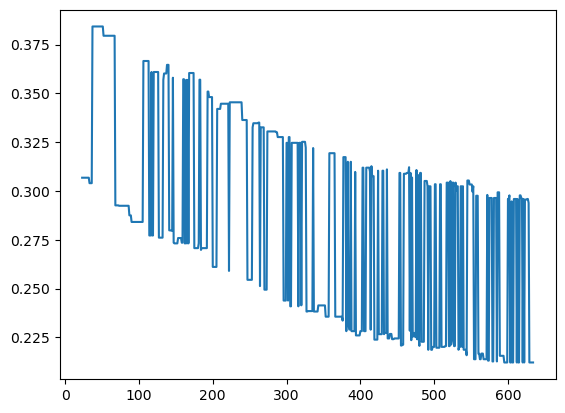

In [33]:
# Log the gic also with the spectrum digg and edges
plt.plot(lg_fitter.metadata['gic_values'])

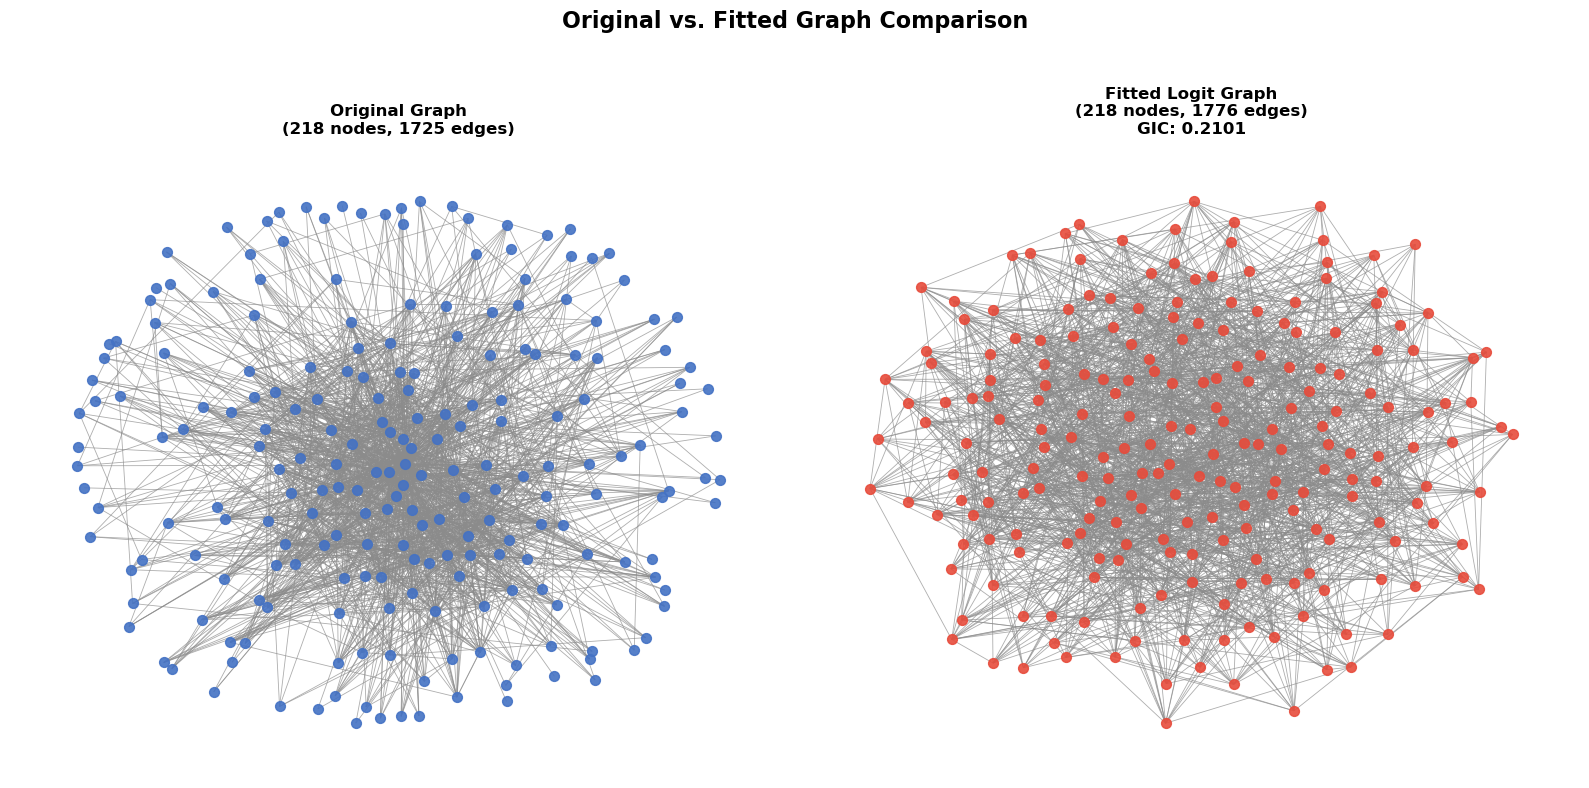

In [34]:
def compare_graphs_visually(original_graph, fitted_graph, metadata=None, figsize=(16, 8), node_size=50, edge_width=0.6):
    """
    Generates a side-by-side plot of the original and fitted graphs.

    Args:
        original_graph (nx.Graph): The original graph.
        fitted_graph (nx.Graph): The fitted graph (can be None if fitting failed).
        metadata (dict, optional): Fitting metadata to display in titles.
        figsize (tuple): The size of the matplotlib figure.
        node_size (int): The size of the nodes in the plot.
        edge_width (float): The width of the edges in the plot.

    Returns:
        matplotlib.figure.Figure: The figure object for the plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Define colors and use a consistent layout for better comparison
    original_node_color = '#4472C4'
    fitted_node_color = '#E74C3C'
    edge_color = '#8B8B8B'
    
    # Calculate layout for original graph
    pos_orig = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
    
    # 1. Plot Original Graph
    ax_orig = axes[0]
    stats_orig = f"{original_graph.number_of_nodes()} nodes, {original_graph.number_of_edges()} edges"
    nx.draw_networkx_edges(original_graph, pos_orig, ax=ax_orig, edge_color=edge_color, width=edge_width, alpha=0.7)
    nx.draw_networkx_nodes(original_graph, pos_orig, ax=ax_orig, node_color=original_node_color, node_size=node_size, alpha=0.9)
    ax_orig.set_title(f'Original Graph\n({stats_orig})', fontweight='bold', pad=10)
    ax_orig.axis('off')

    # 2. Plot Fitted Graph
    ax_fitted = axes[1]
    title = 'Fitted Logit Graph'
    if fitted_graph and metadata and metadata.get('fit_success'):
        stats_fitted = f"{fitted_graph.number_of_nodes()} nodes, {fitted_graph.number_of_edges()} edges"
        gic_val = metadata.get('gic_value', 'N/A')
        gic_text = f"GIC: {gic_val:.4f}" if isinstance(gic_val, (int, float)) else f"GIC: {gic_val}"
        title = f'{title}\n({stats_fitted})\n{gic_text}'
        
        # Calculate separate layout for fitted graph to avoid position mismatch
        pos_fitted = nx.spring_layout(fitted_graph, k=1, iterations=50, seed=42)
        
        nx.draw_networkx_edges(fitted_graph, pos_fitted, ax=ax_fitted, edge_color=edge_color, width=edge_width, alpha=0.7)
        nx.draw_networkx_nodes(fitted_graph, pos_fitted, ax=ax_fitted, node_color=fitted_node_color, node_size=node_size, alpha=0.9)
    else:
        title = f'{title}\n(Fitting Failed)'
        ax_fitted.text(0.5, 0.5, 'Fitting Failed', horizontalalignment='center', verticalalignment='center', transform=ax_fitted.transAxes, fontsize=14, color='red')

    ax_fitted.set_title(title, fontweight='bold', pad=10)
    ax_fitted.axis('off')
    
    fig.suptitle('Original vs. Fitted Graph Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig


# 5. Visualize the results
if lg_fitter.metadata['fit_success']:
    comparison_figure = compare_graphs_visually(target_graph, lg_fitter.fitted_graph, lg_fitter.metadata)
    plt.show()
else:
    print("Fitting failed. No visualization available.")


In [50]:
# Let's proceed with the first loaded graph if available
if not graphs:
    print("\nNo graphs were loaded. Exiting example.")
    exit()

target_graph = graphs[2]
target_filepath = graph_filepaths[target_graph]

# For a single fit, you need to specify a single `d`
sim_params = {
    "d_list": [0, 1, 2],
    "lg_params": {
        "max_iterations": 8000,
        "patience": 10,
        "gic_dist_type": 'KL',
        "er_p": 0.05,
        "min_gic_threshold": 0.1,
        "edge_delta": 50,
        "verbose": True,
    },
    "other_model_n_runs": 5,
    "other_model_params": [
        {'lo': 0.01, 'hi': 0.2},  # ER (probability)
        {'k': {'lo': 2, 'hi': 3, 'step': 1}, 'p': {'lo': 0.01, 'hi': 0.2}},  # WS
        {'lo': 1, 'hi': 3},      # GRG (alpha)
        {'lo': 3, 'hi': 5},     # BA (m)
    ],
    "verbose": True,
}



# Initialize the fitter with the parameters

comparator = GraphModelComparator(**sim_params)
comparator.compare(target_graph, target_filepath)



============================== Processing Graph: 96907622.edges ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4346 (Target: ≤0.1) 📈 Best Spectrum Diff: 572.4733 ⏱️  Patience: 0/10 🔗 Edges: 1766 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3615 (Target: ≤0.1) 📈 Best Spectrum Diff: 474.1305 ⏱️  Patience: 0/10 🔗 Edges: 2633 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4667 (Target: ≤0.1) 📈 Best Spectrum Diff: 403.6383 ⏱️  Patience: 0/10 🔗 Edges: 3453 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2190 (Target: ≤0.1) 📈 Best Spectrum Diff: 358.5826 ⏱️  Patience: 0/10 🔗 Edges: 4234 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4033
   📈 Results Summary
   🏆 Best iteration found: 4,584
   📊 Best spectrum difference: 348.8605
   🔗 Edges in best graph: 4674 (Real graph edges: 4649)
d=0: GIC=0.2042, sigma=-5.4737
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4181 (Target: ≤0.1) 📈 Best Spectrum Diff: 566.4874 ⏱️  Patience: 0/10 🔗 Edges: 1813 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5644 (Target: ≤0.1) 📈 Best Spectrum Diff: 471.9589 ⏱️  Patience: 0/10 🔗 Edges: 2678 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4667 (Target: ≤0.1) 📈 Best Spectrum Diff: 400.6161 ⏱️  Patience: 0/10 🔗 Edges: 3511 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2135 (Target: ≤0.1) 📈 Best Spectrum Diff: 359.2674 ⏱️  Patience: 0/10 🔗 Edges: 4275 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4069
   📈 Results Summary
   🏆 Best iteration found: 4,528
   📊 Best spectrum difference: 351.4274
   🔗 Edges in best graph: 4660 (Real graph edges: 4649)
d=1: GIC=0.4069, sigma=-6.2316
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4336 (Target: ≤0.1) 📈 Best Spectrum Diff: 569.1227 ⏱️  Patience: 0/10 🔗 Edges: 1812 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5529 (Target: ≤0.1) 📈 Best Spectrum Diff: 471.6666 ⏱️  Patience: 0/10 🔗 Edges: 2689 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2589 (Target: ≤0.1) 📈 Best Spectrum Diff: 404.2305 ⏱️  Patience: 0/10 🔗 Edges: 3486 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2111 (Target: ≤0.1) 📈 Best Spectrum Diff: 364.2727 ⏱️  Patience: 0/10 🔗 Edges: 4277 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4048
   📈 Results Summary
   🏆 Best iteration found: 4,409
   📊 Best spectrum difference: 358.2911
   🔗 Edges in best graph: 4577 (Real graph edges: 4649)
d=2: GIC=0.2048, sigma=-80.5871
Best LG fit found with GIC: 0.2042

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2723181008317491
Tes

In [52]:
comparator.summary_df

,graph_filename,model,gic_value,param,fit_success,nodes,edges,density,avg_clustering,avg_path_length,diameter,assortativity,num_components,largest_component_size
0,96907622.edges,Original,NaN,N/A,True,187,4649,0.267322,0.598147,1.749955,4,-0.223390,2,183
1,96907622.edges,LG,0.204187,"d=0, sigma=-5.4737",True,187,4674,0.268760,0.269265,1.731240,2,-0.021158,1,187
2,96907622.edges,ER,0.272318,0.2,True,187,3385,0.194641,0.196904,1.806107,3,-0.001703,1,187
3,96907622.edges,BA,0.721498,5.0,True,187,910,0.052326,0.129281,2.433673,4,-0.115371,1,187
4,96907622.edges,WS,1.599264,20.2,True,187,4675,0.268817,0.266414,1.731183,2,-0.042454,1,187
5,96907622.edges,GRG,2.135166,1.0,True,187,16891,0.971249,0.975021,1.028751,2,-0.046187,1,187


### Comparison other models

comparing multiple models

In [60]:
import re

ids = os.listdir('../../data/reddit_connected/')

ids = [int(re.search(r'component_(\d+)\.edges$', id).group(1)) for id in ids if id.endswith('.edges')]

print(ids)

[6699, 10792, 6642, 29885, 21698, 4899, 6601, 6658, 6932, 5576, 11002, 30635, 30101, 5917, 3586, 18245, 17743, 29275, 7632, 27556]


In [61]:
sim_params = {
    "d_list": [0, 1, 2],
    "lg_params": {
        "max_iterations": 8000,
        "patience": 10,
        "gic_dist_type": 'KL',
        "er_p": 0.001,
        "min_gic_threshold": 0.1,
        "edge_delta": 50,
        "verbose": True,
    },
    "other_model_n_runs": 5,
    "other_model_params": [
        {'lo': 0.01, 'hi': 0.2},  # ER (probability)
        {'k': {'lo': 2, 'hi': 3, 'step': 1}, 'p': {'lo': 0.01, 'hi': 0.2}},  # WS
        {'lo': 1, 'hi': 3},      # GRG (alpha)
        {'lo': 3, 'hi': 5},     # BA (m)
    ],
    "verbose": True,
}



graph_files = []
for id in ids:
    graph_files.append(f'../../data/reddit_connected/component_{id}.edges')
print(len(graph_files))

graphs = [nx.read_edgelist(f, nodetype=int) for f in graph_files]


20


In [62]:
graph_files

['../../data/reddit_connected/component_6699.edges',
 '../../data/reddit_connected/component_10792.edges',
 '../../data/reddit_connected/component_6642.edges',
 '../../data/reddit_connected/component_29885.edges',
 '../../data/reddit_connected/component_21698.edges',
 '../../data/reddit_connected/component_4899.edges',
 '../../data/reddit_connected/component_6601.edges',
 '../../data/reddit_connected/component_6658.edges',
 '../../data/reddit_connected/component_6932.edges',
 '../../data/reddit_connected/component_5576.edges',
 '../../data/reddit_connected/component_11002.edges',
 '../../data/reddit_connected/component_30635.edges',
 '../../data/reddit_connected/component_30101.edges',
 '../../data/reddit_connected/component_5917.edges',
 '../../data/reddit_connected/component_3586.edges',
 '../../data/reddit_connected/component_18245.edges',
 '../../data/reddit_connected/component_17743.edges',
 '../../data/reddit_connected/component_29275.edges',
 '../../data/reddit_connected/compone

In [64]:
comparators = []
folder_name = 'runs/fitted_graphs_comparison_reddit2'
os.makedirs(folder_name, exist_ok=True)

for graph_file in graph_files:
    try:
        print(f"Loading graph from: {graph_file}")
        original_graph = nx.read_edgelist(graph_file, nodetype=int, delimiter=',')
        print(original_graph.number_of_nodes(), original_graph.number_of_edges())

        n_iteration = 10_000
        sim_params['lg_params']['max_iterations'] = n_iteration

        # Run the comparison
        comparator = GraphModelComparator(**sim_params)
        comparator.compare(original_graph, graph_file)
    except Exception as e:
        print(f"Error graph from {graph_file}: {e}")
        continue

    comparators.append(comparator)
    import pickle
    graph_name = graph_file.split('/')[-1].split('.')[0]
    with open(f'{folder_name}/comparators_{graph_name}.pkl', 'wb') as f:
        pickle.dump(comparators, f)



Loading graph from: ../../data/reddit_connected/component_6699.edges
1142 1456

============================== Processing Graph: component_6699.edges ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2438 (Target: ≤0.1) 📈 Best Spectrum Diff: 300.4359 ⏱️  Patience: 0/10 🔗 Edges: 1456 (Target: 1456)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2321
   📈 Results Summary
   🏆 Best iteration found: 972
   📊 Best spectrum difference: 300.4359
   🔗 Edges in best graph: 1436 (Real graph edges: 1456)
d=0: GIC=0.2446, sigma=-1.7434
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2601 (Target: ≤0.1) 📈 Best Spectrum Diff: 300.3366 ⏱️  Patience: 0/10 🔗 Edges: 1386 (Target: 1456)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2473
   📈 Results Summary
   🏆 Best iteration found: 969
   📊 Best spectrum difference: 300.3366
   🔗 Edges in best graph: 1361 (Real graph edges: 1456)
d=1: GIC=0.2583, sigma=-7.0675
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2627 (Target: ≤0.1) 📈 Best Spectrum Diff: 301.1167 ⏱️  Patience: 0/10 🔗 Edges: 1385 (Target: 1456)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2399
   📈 Results Summary
   🏆 Best iteration found: 1,072
   📊 Best spectrum difference: 301.0802
   🔗 Edges in best graph: 1455 (Real graph edges: 1456)
d=2: GIC=0.2453, sigma=-7.7251
Best LG fit found with GIC: 0.2446

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 5.923369388904986
Testing the selected model for WS
WS gic: 0.41119276106877034
Testing the selected model for GRG
GRG gic: 9.97262047146286
Testing the selected model for BA
BA gic: 1.9828325191828304
WS fitting - GIC: 0.4112, Param: 20.2000
BA fitting - GIC: 1.9828, Param: 3.2222
ER fitting - GIC: 5.9234, Param: 0.0100
GRG fitting - GIC: 9.9726, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6084
   📈 Results Summary
   🏆 Best iteration found: 519
   📊 Best spectrum difference: 1027.2420
   🔗 Edges in best graph: 2149 (Real graph edges: 2100)
d=0: GIC=0.6123, sigma=-1.2097
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6147
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: 1026.5480
   🔗 Edges in best graph: 1779 (Real graph edges: 2100)
d=1: GIC=0.6673, sigma=-10.0079
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6373
   📈 Results Summary
   🏆 Best iteration found: 400
   📊 Best spectrum difference: 1025.0299
   🔗 Edges in best graph: 2082 (Real graph edges: 2100)
d=2: GIC=0.6415, sigma=-11.0721
Best LG fit found with GIC: 0.6123

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 5.511961022704769
Testing the selected model for WS
WS gic: 0.8107293572093979
Testing the selected model for GRG
GRG gic: 6.259643438623508
Testing the selected model for BA
BA gic: 1.6009866699062185
WS fitting - GIC: 0.8107, Param: 20.1578
BA fitting - GIC: 1.6010, Param: 3.0000
ER fitting - GIC: 5.5120, Param: 0.0311
GRG fitting - GIC: 6.2596, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/reddit_connected/component_6642.edges
1918 2285

============================== Processing Graph: component_6642.edges

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4134
   📈 Results Summary
   🏆 Best iteration found: 368
   📊 Best spectrum difference: 755.0222
   🔗 Edges in best graph: 2206 (Real graph edges: 2285)
d=0: GIC=0.4268, sigma=-0.7023
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3898
   📈 Results Summary
   🏆 Best iteration found: 315
   📊 Best spectrum difference: 754.3378
   🔗 Edges in best graph: 2145 (Real graph edges: 2285)
d=1: GIC=0.4177, sigma=-8.2751
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4310
   📈 Results Summary
   🏆 Best iteration found: 564
   📊 Best spectrum difference: 755.1191
   🔗 Edges in best graph: 2336 (Real graph edges: 2285)
d=2: GIC=0.4306, sigma=-8.3476
Best LG fit found with GIC: 0.4177

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 7.0350454314619935
Testing the selected model for WS
WS gic: 0.5988619114758621
Testing the selected model for GRG
GRG gic: 8.252000196198221
Testing the selected model for BA
BA gic: 1.681336087481749
WS fitting - GIC: 0.5989, Param: 20.2000
BA fitting - GIC: 1.6813, Param: 3.8889
ER fitting - GIC: 7.0350, Param: 0.0311
GRG fitting - GIC: 8.2520, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/reddit_connected/component_29885.edges
1747 2866

============================== Processing Graph: component_29885.edges

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2076 (Target: ≤0.1) 📈 Best Spectrum Diff: 512.0417 ⏱️  Patience: 0/10 🔗 Edges: 2431 (Target: 2866)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1518
   📈 Results Summary
   🏆 Best iteration found: 1,483
   📊 Best spectrum difference: 510.4190
   🔗 Edges in best graph: 2894 (Real graph edges: 2866)
d=0: GIC=0.1513, sigma=-0.9096
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2089 (Target: ≤0.1) 📈 Best Spectrum Diff: 511.1697 ⏱️  Patience: 0/10 🔗 Edges: 2354 (Target: 2866)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1430
   📈 Results Summary
   🏆 Best iteration found: 1,586
   📊 Best spectrum difference: 507.9914
   🔗 Edges in best graph: 2917 (Real graph edges: 2866)
d=1: GIC=0.1446, sigma=-7.2999
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2010 (Target: ≤0.1) 📈 Best Spectrum Diff: 512.3365 ⏱️  Patience: 0/10 🔗 Edges: 2425 (Target: 2866)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1567
   📈 Results Summary
   🏆 Best iteration found: 1,474
   📊 Best spectrum difference: 511.1465
   🔗 Edges in best graph: 2897 (Real graph edges: 2866)
d=2: GIC=0.1579, sigma=-8.0713
Best LG fit found with GIC: 0.1446

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 5.032934950829241
Testing the selected model for WS
WS gic: 0.4337232845332883
Testing the selected model for GRG
GRG gic: 11.381968846636054
Testing the selected model for BA
BA gic: 0.9672865786969265
WS fitting - GIC: 0.4337, Param: 20.2000
BA fitting - GIC: 0.9673, Param: 3.2222
ER fitting - GIC: 5.0329, Param: 0.0100
GRG fitting - GIC: 11.3820, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6105
   📈 Results Summary
   🏆 Best iteration found: 154
   📊 Best spectrum difference: 650.6585
   🔗 Edges in best graph: 1428 (Real graph edges: 1762)
d=0: GIC=0.6697, sigma=-0.8784
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6414
   📈 Results Summary
   🏆 Best iteration found: 559
   📊 Best spectrum difference: 649.6964
   🔗 Edges in best graph: 1658 (Real graph edges: 1762)
d=1: GIC=0.6319, sigma=-8.3232
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6267
   📈 Results Summary
   🏆 Best iteration found: 636
   📊 Best spectrum difference: 650.0868
   🔗 Edges in best graph: 1732 (Real graph edges: 1762)
d=2: GIC=0.6500, sigma=-8.2467
Best LG fit found with GIC: 0.6319

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 5.5468251394555
Testing the selected model for WS
WS gic: 0.7714212383283252
Testing the selected model for GRG
GRG gic: 6.287363931761064
Testing the selected model for BA
BA gic: 2.015997734429087
WS fitting - GIC: 0.7714, Param: 20.2000
BA fitting - GIC: 2.0160, Param: 3.8889
ER fitting - GIC: 5.5468, Param: 0.0311
GRG fitting - GIC: 6.2874, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/reddit_connected/component_4899.edges
1474 1749

============================== Processing Graph: component_4899.edges ====

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5178
   📈 Results Summary
   🏆 Best iteration found: 536
   📊 Best spectrum difference: 689.8792
   🔗 Edges in best graph: 1474 (Real graph edges: 1749)
d=0: GIC=0.5679, sigma=-0.7474
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4922
   📈 Results Summary
   🏆 Best iteration found: 763
   📊 Best spectrum difference: 689.9119
   🔗 Edges in best graph: 1606 (Real graph edges: 1749)
d=1: GIC=0.5308, sigma=-9.0878
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5130
   📈 Results Summary
   🏆 Best iteration found: 700
   📊 Best spectrum difference: 689.0919
   🔗 Edges in best graph: 1725 (Real graph edges: 1749)
d=2: GIC=0.5305, sigma=-9.5983
Best LG fit found with GIC: 0.5305

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 5.817255978988322
Testing the selected model for WS
WS gic: 0.7121186020421246
Testing the selected model for GRG
GRG gic: 7.171943452252586
Testing the selected model for BA
BA gic: 1.490152856024061
WS fitting - GIC: 0.7121, Param: 20.1789
BA fitting - GIC: 1.4902, Param: 3.4444
ER fitting - GIC: 5.8173, Param: 0.0311
GRG fitting - GIC: 7.1719, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/reddit_connected/component_6601.edges
1243 1367

============================== Processing Graph: component_6601.edges ==

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4117
   📈 Results Summary
   🏆 Best iteration found: 689
   📊 Best spectrum difference: 408.3331
   🔗 Edges in best graph: 1266 (Real graph edges: 1367)
d=0: GIC=0.4684, sigma=-1.3590
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4440
   📈 Results Summary
   🏆 Best iteration found: 808
   📊 Best spectrum difference: 408.8482
   🔗 Edges in best graph: 1367 (Real graph edges: 1367)
d=1: GIC=0.4516, sigma=-7.5293
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4252
   📈 Results Summary
   🏆 Best iteration found: 756
   📊 Best spectrum difference: 409.3098
   🔗 Edges in best graph: 1350 (Real graph edges: 1367)
d=2: GIC=0.4537, sigma=-7.5104
Best LG fit found with GIC: 0.4516

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 6.916765483549677
Testing the selected model for WS
WS gic: 0.5806112633098451
Testing the selected model for GRG
GRG gic: 7.829798692847488
Testing the selected model for BA
BA gic: 2.206782974711918
WS fitting - GIC: 0.5806, Param: 20.2000
BA fitting - GIC: 2.2068, Param: 3.4444
ER fitting - GIC: 6.9168, Param: 0.0311
GRG fitting - GIC: 7.8298, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/reddit_connected/component_6658.edges
1400 1737

============================== Processing Graph: component_6658.edges ==

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2784 (Target: ≤0.1) 📈 Best Spectrum Diff: 259.9652 ⏱️  Patience: 0/10 🔗 Edges: 1671 (Target: 1737)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2605
   📈 Results Summary
   🏆 Best iteration found: 1,035
   📊 Best spectrum difference: 259.8789
   🔗 Edges in best graph: 1701 (Real graph edges: 1737)
d=0: GIC=0.2675, sigma=-2.1180
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2999 (Target: ≤0.1) 📈 Best Spectrum Diff: 261.4268 ⏱️  Patience: 0/10 🔗 Edges: 1738 (Target: 1737)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2972
   📈 Results Summary
   🏆 Best iteration found: 1,043
   📊 Best spectrum difference: 260.6984
   🔗 Edges in best graph: 1781 (Real graph edges: 1737)
d=1: GIC=0.2953, sigma=-7.0096
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2828 (Target: ≤0.1) 📈 Best Spectrum Diff: 260.3196 ⏱️  Patience: 0/10 🔗 Edges: 1759 (Target: 1737)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2886
   📈 Results Summary
   🏆 Best iteration found: 1,012
   📊 Best spectrum difference: 260.2918
   🔗 Edges in best graph: 1772 (Real graph edges: 1737)
d=2: GIC=0.2783, sigma=-7.7928
Best LG fit found with GIC: 0.2675

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 7.983213908373683
Testing the selected model for WS
WS gic: 0.44667244129967343
Testing the selected model for GRG
GRG gic: 9.53453032000979
Testing the selected model for BA
BA gic: 2.0915376782542854
WS fitting - GIC: 0.4467, Param: 20.2000
BA fitting - GIC: 2.0915, Param: 3.6667
ER fitting - GIC: 7.9832, Param: 0.0311
GRG fitting - GIC: 9.5345, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4663
   📈 Results Summary
   🏆 Best iteration found: 424
   📊 Best spectrum difference: 622.3862
   🔗 Edges in best graph: 1437 (Real graph edges: 1649)
d=0: GIC=0.5094, sigma=-0.8693
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5011
   📈 Results Summary
   🏆 Best iteration found: 782
   📊 Best spectrum difference: 620.8736
   🔗 Edges in best graph: 1663 (Real graph edges: 1649)
d=1: GIC=0.5094, sigma=-8.7369
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5232
   📈 Results Summary
   🏆 Best iteration found: 574
   📊 Best spectrum difference: 621.6354
   🔗 Edges in best graph: 1580 (Real graph edges: 1649)
d=2: GIC=0.5413, sigma=-8.0841
Best LG fit found with GIC: 0.5094

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 5.943872738713772
Testing the selected model for WS
WS gic: 0.6686878549900983
Testing the selected model for GRG
GRG gic: 7.002456558296139
Testing the selected model for BA
BA gic: 1.9925895472279604
WS fitting - GIC: 0.6687, Param: 20.1789
BA fitting - GIC: 1.9926, Param: 3.4444
ER fitting - GIC: 5.9439, Param: 0.0311
GRG fitting - GIC: 7.0025, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/reddit_connected/component_5576.edges
1142 1370

============================== Processing Graph: component_5576.edges =

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2875 (Target: ≤0.1) 📈 Best Spectrum Diff: 301.0128 ⏱️  Patience: 0/10 🔗 Edges: 1300 (Target: 1370)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2696
   📈 Results Summary
   🏆 Best iteration found: 982
   📊 Best spectrum difference: 301.0128
   🔗 Edges in best graph: 1286 (Real graph edges: 1370)
d=0: GIC=0.2863, sigma=-1.7798
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2763 (Target: ≤0.1) 📈 Best Spectrum Diff: 303.7355 ⏱️  Patience: 0/10 🔗 Edges: 1344 (Target: 1370)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2784
   📈 Results Summary
   🏆 Best iteration found: 1,061
   📊 Best spectrum difference: 303.3580
   🔗 Edges in best graph: 1400 (Real graph edges: 1370)
d=1: GIC=0.2774, sigma=-7.0946
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2796
   📈 Results Summary
   🏆 Best iteration found: 837
   📊 Best spectrum difference: 304.7005
   🔗 Edges in best graph: 1315 (Real graph edges: 1370)
d=2: GIC=0.2906, sigma=-7.6852
Best LG fit found with GIC: 0.2774

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 8.109177616526633
Testing the selected model for WS
WS gic: 0.4256807033433182
Testing the selected model for GRG
GRG gic: 9.577401554087604
Testing the selected model for BA
BA gic: 2.0781190789384376
WS fitting - GIC: 0.4257, Param: 20.1789
BA fitting - GIC: 2.0781, Param: 3.0000
ER fitting - GIC: 8.1092, Param: 0.0311
GRG fitting - GIC: 9.5774, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/reddit_connected/component_11002.edges
3421 3656

============================== Processing Graph: component_11002.edges

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 5829 (Real graph edges: 3656)
d=0: GIC=0.9043, sigma=-0.2466
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 5839 (Real graph edges: 3656)
d=1: GIC=0.8949, sigma=-14.5966
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 5858 (Real graph edges: 3656)
d=2: GIC=0.8990, sigma=-48.7904
Best LG fit found with GIC: 0.8949

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.05082188803347
Testing the selected model for WS
WS gic: 1.2465502354631974
Testing the selected model for GRG
GRG gic: 3.4043581256716133
Testing the selected model for BA
BA gic: 2.702900229706303
WS fitting - GIC: 1.2466, Param: 20.2000
BA fitting - GIC: 2.7029, Param: 5.0000
ER fitting - GIC: 3.0508, Param: 0.0311
GRG fitting - GIC: 3.4044, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/reddit_connected/component_30635.edges
1461 1945

============================== Processing Graph: component_30635.edges =========

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2740 (Target: ≤0.1) 📈 Best Spectrum Diff: 502.1803 ⏱️  Patience: 0/10 🔗 Edges: 1933 (Target: 1945)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2673
   📈 Results Summary
   🏆 Best iteration found: 1,063
   📊 Best spectrum difference: 501.4281
   🔗 Edges in best graph: 1991 (Real graph edges: 1945)
d=0: GIC=0.2666, sigma=-0.9830
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2852 (Target: ≤0.1) 📈 Best Spectrum Diff: 503.8129 ⏱️  Patience: 0/10 🔗 Edges: 1848 (Target: 1945)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2644
   📈 Results Summary
   🏆 Best iteration found: 1,142
   📊 Best spectrum difference: 502.3091
   🔗 Edges in best graph: 1982 (Real graph edges: 1945)
d=1: GIC=0.2646, sigma=-7.4555
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2807 (Target: ≤0.1) 📈 Best Spectrum Diff: 503.2361 ⏱️  Patience: 0/10 🔗 Edges: 1913 (Target: 1945)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2629
   📈 Results Summary
   🏆 Best iteration found: 1,074
   📊 Best spectrum difference: 502.5699
   🔗 Edges in best graph: 1988 (Real graph edges: 1945)
d=2: GIC=0.2674, sigma=-8.1355
Best LG fit found with GIC: 0.2646

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 7.787361098912315
Testing the selected model for WS
WS gic: 0.4879108608333292
Testing the selected model for GRG
GRG gic: 9.664817392868922
Testing the selected model for BA
BA gic: 1.565859543689446
WS fitting - GIC: 0.4879, Param: 20.2000
BA fitting - GIC: 1.5659, Param: 3.0000
ER fitting - GIC: 7.7874, Param: 0.0311
GRG fitting - GIC: 9.6648, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1464 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.1211 ⏱️  Patience: 0/10 🔗 Edges: 1449 (Target: 1606)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1154
   📈 Results Summary
   🏆 Best iteration found: 1,135
   📊 Best spectrum difference: 321.2460
   🔗 Edges in best graph: 1566 (Real graph edges: 1606)
d=0: GIC=0.1325, sigma=-1.6182
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1721 (Target: ≤0.1) 📈 Best Spectrum Diff: 321.0089 ⏱️  Patience: 0/10 🔗 Edges: 1402 (Target: 1606)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1224
   📈 Results Summary
   🏆 Best iteration found: 1,221
   📊 Best spectrum difference: 320.1160
   🔗 Edges in best graph: 1606 (Real graph edges: 1606)
d=1: GIC=0.1336, sigma=-7.0489
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.1772 (Target: ≤0.1) 📈 Best Spectrum Diff: 322.4496 ⏱️  Patience: 0/10 🔗 Edges: 1444 (Target: 1606)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.1455
   📈 Results Summary
   🏆 Best iteration found: 1,096
   📊 Best spectrum difference: 322.2015
   🔗 Edges in best graph: 1538 (Real graph edges: 1606)
d=2: GIC=0.1585, sigma=-7.3898
Best LG fit found with GIC: 0.1325

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 5.766954418443832
Testing the selected model for WS
WS gic: 0.3227823278664476
Testing the selected model for GRG
GRG gic: 11.524220049464017
Testing the selected model for BA
BA gic: 1.5933746172221048
WS fitting - GIC: 0.3228, Param: 20.2000
BA fitting - GIC: 1.5934, Param: 3.2222
ER fitting - GIC: 5.7670, Param: 0.0100
GRG fitting - GIC: 11.5242, Param: 1.0000

--- Calculating graph attributes ---
Loading graph f

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3918
   📈 Results Summary
   🏆 Best iteration found: 722
   📊 Best spectrum difference: 464.6724
   🔗 Edges in best graph: 1340 (Real graph edges: 1458)
d=0: GIC=0.4257, sigma=-1.2008
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4137 (Target: ≤0.1) 📈 Best Spectrum Diff: 463.3900 ⏱️  Patience: 0/10 🔗 Edges: 1476 (Target: 1458)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4040
   📈 Results Summary
   🏆 Best iteration found: 760
   📊 Best spectrum difference: 463.3900
   🔗 Edges in best graph: 1269 (Real graph edges: 1458)
d=1: GIC=0.4582, sigma=-7.7463
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4418
   📈 Results Summary
   🏆 Best iteration found: 969
   📊 Best spectrum difference: 463.9038
   🔗 Edges in best graph: 1504 (Real graph edges: 1458)
d=2: GIC=0.4421, sigma=-8.2582
Best LG fit found with GIC: 0.4257

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 6.565928830424848
Testing the selected model for WS
WS gic: 0.599852348863604
Testing the selected model for GRG
GRG gic: 7.8181882523429485
Testing the selected model for BA
BA gic: 1.8825375099293087
WS fitting - GIC: 0.5999, Param: 20.1789
BA fitting - GIC: 1.8825, Param: 3.2222
ER fitting - GIC: 6.5659, Param: 0.0311
GRG fitting - GIC: 7.8182, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/reddit_connected/component_3586.edges
1012 1112

============================== Processing Graph: component_3586.edges =

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5125
   📈 Results Summary
   🏆 Best iteration found: 521
   📊 Best spectrum difference: 496.2810
   🔗 Edges in best graph: 876 (Real graph edges: 1112)
d=0: GIC=0.6305, sigma=-1.1585
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5142
   📈 Results Summary
   🏆 Best iteration found: 986
   📊 Best spectrum difference: 496.8198
   🔗 Edges in best graph: 1156 (Real graph edges: 1112)
d=1: GIC=0.5199, sigma=-8.6035
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5161
   📈 Results Summary
   🏆 Best iteration found: 686
   📊 Best spectrum difference: 497.0322
   🔗 Edges in best graph: 952 (Real graph edges: 1112)
d=2: GIC=0.5671, sigma=-7.7875
Best LG fit found with GIC: 0.5199

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 6.067108677001787
Testing the selected model for WS
WS gic: 0.6894724687335035
Testing the selected model for GRG
GRG gic: 6.991031133538122
Testing the selected model for BA
BA gic: 1.8678717806326441
WS fitting - GIC: 0.6895, Param: 20.1578
BA fitting - GIC: 1.8679, Param: 3.0000
ER fitting - GIC: 6.0671, Param: 0.0522
GRG fitting - GIC: 6.9910, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/reddit_connected/component_18245.edges
1432 1493

============================== Processing Graph: component_18245.edges 

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2799
   📈 Results Summary
   🏆 Best iteration found: 91
   📊 Best spectrum difference: 1273.1132
   🔗 Edges in best graph: 1136 (Real graph edges: 1493)
d=0: GIC=1.4266, sigma=-0.5280
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.2868 (Target: ≤0.1) 📈 Best Spectrum Diff: 1270.3117 ⏱️  Patience: 0/10 🔗 Edges: 1291 (Target: 1493)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.2298
   📈 Results Summary
   🏆 Best iteration found: 789
   📊 Best spectrum difference: 1270.3117
   🔗 Edges in best graph: 1210 (Real graph edges: 1493)
d=1: GIC=1.3480, sigma=-16.6648
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.3618 (Target: ≤0.1) 📈 Best Spectrum Diff: 1273.5043 ⏱️  Patience: 0/10 🔗 Edges: 1021 (Target: 1493)
📊 Iteration 2,000: 🎯 GIC (KL): 1.3661 (Target: ≤0.1) 📈 Best Spectrum Diff: 1273.5027 ⏱️  Patience: 0/10 🔗 Edges: 1020 (Target: 1493)
📊 Iteration 3,000: 🎯 GIC (KL): 1.3658 (Target: ≤0.1) 📈 Best Spectrum Diff: 1273.4997 ⏱️  Patience: 0/10 🔗 Edges: 1018 (Target: 1493)
📊 Iteration 4,000: 🎯 GIC (KL): 1.3641 (Target: ≤0.1) 📈 Best Spectrum Diff: 1273.4951 ⏱️  Patience: 0/10 🔗 Edges: 1016 (Target: 1493)
📊 Iteration 5,000: 🎯 GIC (KL): 1.3578 (Target: ≤0.1) 📈 Best Spectrum Diff: 1273.4938 ⏱️  Patience: 0/10 🔗 Edges: 1015 (Target: 1493)
📊 Iteration 6,000: 🎯 GIC (KL): 1.3565 (Target: ≤0.1) 📈 Best Spectrum Diff: 1273.4926 ⏱️  Patience: 0/10 🔗 Edges: 1014 (Target: 1493)
📊 Iteration 7,000: 🎯 GIC (KL): 1.3535 (Target: ≤0.1) 📈 Best Spectrum Diff: 1273.4919 ⏱️  Patience: 0/10 🔗 Edges: 1013 (Target: 1493)
📊 Iteration 8,000: 🎯 GIC (KL): 1.3585 (Target: ≤0.1) 📈 Best Spectrum 

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3956 (Target: ≤0.1) 📈 Best Spectrum Diff: 584.4113 ⏱️  Patience: 0/10 🔗 Edges: 1724 (Target: 1681)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3901
   📈 Results Summary
   🏆 Best iteration found: 856
   📊 Best spectrum difference: 584.4113
   🔗 Edges in best graph: 1588 (Real graph edges: 1681)
d=0: GIC=0.4155, sigma=-0.8924
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3927 (Target: ≤0.1) 📈 Best Spectrum Diff: 584.4694 ⏱️  Patience: 0/10 🔗 Edges: 1629 (Target: 1681)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3883
   📈 Results Summary
   🏆 Best iteration found: 808
   📊 Best spectrum difference: 584.4694
   🔗 Edges in best graph: 1460 (Real graph edges: 1681)
d=1: GIC=0.4158, sigma=-8.1250
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4144 (Target: ≤0.1) 📈 Best Spectrum Diff: 584.4149 ⏱️  Patience: 0/10 🔗 Edges: 1601 (Target: 1681)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3947
   📈 Results Summary
   🏆 Best iteration found: 964
   📊 Best spectrum difference: 584.4149
   🔗 Edges in best graph: 1567 (Real graph edges: 1681)
d=2: GIC=0.4136, sigma=-8.8083
Best LG fit found with GIC: 0.4136

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 6.750674999595367
Testing the selected model for WS
WS gic: 0.6175438319242803
Testing the selected model for GRG
GRG gic: 8.453018143712992
Testing the selected model for BA
BA gic: 1.2939851452283264
WS fitting - GIC: 0.6175, Param: 20.2000
BA fitting - GIC: 1.2940, Param: 3.8889
ER fitting - GIC: 6.7507, Param: 0.0311
GRG fitting - GIC: 8.4530, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from:

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4482
   📈 Results Summary
   🏆 Best iteration found: 688
   📊 Best spectrum difference: 418.5944
   🔗 Edges in best graph: 1055 (Real graph edges: 1237)
d=0: GIC=0.5124, sigma=-1.3331
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4842 (Target: ≤0.1) 📈 Best Spectrum Diff: 417.4933 ⏱️  Patience: 0/10 🔗 Edges: 1157 (Target: 1237)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4492
   📈 Results Summary
   🏆 Best iteration found: 1,028
   📊 Best spectrum difference: 417.4160
   🔗 Edges in best graph: 1181 (Real graph edges: 1237)
d=1: GIC=0.4612, sigma=-7.6065
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4450 (Target: ≤0.1) 📈 Best Spectrum Diff: 416.8484 ⏱️  Patience: 0/10 🔗 Edges: 1240 (Target: 1237)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4242
   📈 Results Summary
   🏆 Best iteration found: 787
   📊 Best spectrum difference: 416.8484
   🔗 Edges in best graph: 1046 (Real graph edges: 1237)
d=2: GIC=0.5295, sigma=-9.4073
Best LG fit found with GIC: 0.4612

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 6.062907851254664
Testing the selected model for WS
WS gic: 0.6454995227480763
Testing the selected model for GRG
GRG gic: 7.640760911001473
Testing the selected model for BA
BA gic: 2.493328528412011
WS fitting - GIC: 0.6455, Param: 20.2000
BA fitting - GIC: 2.4933, Param: 3.6667
ER fitting - GIC: 6.0629, Param: 0.0522
GRG fitting - GIC: 7.6408, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: 

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5495
   📈 Results Summary
   🏆 Best iteration found: 819
   📊 Best spectrum difference: 595.6333
   🔗 Edges in best graph: 1453 (Real graph edges: 1430)
d=0: GIC=0.5437, sigma=-0.9571
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5605
   📈 Results Summary
   🏆 Best iteration found: 631
   📊 Best spectrum difference: 594.1300
   🔗 Edges in best graph: 1204 (Real graph edges: 1430)
d=1: GIC=0.6536, sigma=-8.7150
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5381
   📈 Results Summary
   🏆 Best iteration found: 940
   📊 Best spectrum difference: 596.0861
   🔗 Edges in best graph: 1478 (Real graph edges: 1430)
d=2: GIC=0.5393, sigma=-8.2435
Best LG fit found with GIC: 0.5393

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 6.027298666523842
Testing the selected model for WS
WS gic: 0.7463770603352842
Testing the selected model for GRG
GRG gic: 6.718352848200856
Testing the selected model for BA
BA gic: 1.7276869657566016
WS fitting - GIC: 0.7464, Param: 20.2000
BA fitting - GIC: 1.7277, Param: 3.2222
ER fitting - GIC: 6.0273, Param: 0.0311
GRG fitting - GIC: 6.7184, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/reddit_connected/component_27556.edges
1161 1416

============================== Processing Graph: component_27556.edges

🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3467
   📈 Results Summary
   🏆 Best iteration found: 896
   📊 Best spectrum difference: 442.1685
   🔗 Edges in best graph: 1440 (Real graph edges: 1416)
d=0: GIC=0.3499, sigma=-1.1215
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3612 (Target: ≤0.1) 📈 Best Spectrum Diff: 441.5692 ⏱️  Patience: 0/10 🔗 Edges: 1342 (Target: 1416)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3286
   📈 Results Summary
   🏆 Best iteration found: 1,041
   📊 Best spectrum difference: 440.8552
   🔗 Edges in best graph: 1379 (Real graph edges: 1416)
d=1: GIC=0.3468, sigma=-8.1290
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/10000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3467 (Target: ≤0.1) 📈 Best Spectrum Diff: 442.6705 ⏱️  Patience: 0/10 🔗 Edges: 1463 (Target: 1416)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3488
   📈 Results Summary
   🏆 Best iteration found: 935
   📊 Best spectrum difference: 442.6705
   🔗 Edges in best graph: 1404 (Real graph edges: 1416)
d=2: GIC=0.3601, sigma=-8.9981
Best LG fit found with GIC: 0.3468

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 6.842490816120648
Testing the selected model for WS
WS gic: 0.5215761461251521
Testing the selected model for GRG
GRG gic: 8.53461321408606
Testing the selected model for BA
BA gic: 1.9806599890536554
WS fitting - GIC: 0.5216, Param: 20.2000
BA fitting - GIC: 1.9807, Param: 3.4444
ER fitting - GIC: 6.8425, Param: 0.0311
GRG fitting - GIC: 8.5346, Param: 1.0000

--- Calculating graph attributes ---


In [37]:
21321

21321